<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 35px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>User Clustering: <strong>E-Commerce</strong></center></div>
<div style= "font-size: 30px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Organizing all variables and data to the models phase</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Processamento e Modelação de Big Data 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

### imports

In [66]:
# Importações Básicas
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import matplotlib.pyplot as plt

## 1. Leitura dos dados

In [67]:
# Inicializa a sessão Spark
spark = SparkSession.builder.appName("PMBD - Data Preparation and Data Engineering") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.executor.instances", "10") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")  # Pode ser ajustado para "INFO" durante o desenvolvimento
print(spark.sparkContext._jsc.sc().isStopped())  # False -> tudo bem; True -> Spark está desligado

False


In [68]:
# Leitura de dados
data_dir = '../data/'

schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", LongType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("user_id", LongType(), True),
    StructField("user_session", StringType(), True)
])

ec_user = spark.read.parquet(data_dir + "user_df.parquet", schema=schema)

In [69]:
# ec_user = ec_user.repartition(36, "total_views")

In [70]:
ec_user.show()

+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+
|  user_id|average_price|total_views|electronics|appliances|furniture|computers|apparel|construction|auto|kids|sport|accessories|
+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+
|520088904|      444.383|         17|          9|         0|        0|        8|      0|           0|   0|   0|    0|          0|
|530496790|       293.65|          1|          0|         1|        0|        0|      0|           0|   0|   0|    0|          0|
|518085591|      492.313|          3|          0|         1|        2|        0|      0|           0|   0|   0|    0|          0|
|558856683|       183.27|          3|          3|         0|        0|        0|      0|           0|   0|   0|    0|          0|
|520772685|      432.336|         17|          0|         0|        0|       17|      0|  

## Clustering Algorithms

In [71]:
feature_cols = ec_user.columns
feature_cols.pop(0)

'user_id'

In [72]:
from pyspark.ml.feature import VectorAssembler, MaxAbsScaler

In [73]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_prescale")
client_features = assembler.transform(ec_user)

scaler = MaxAbsScaler(inputCol="features_prescale", outputCol="features")
client_features = scaler.fit(client_features).transform(client_features).repartition(36, "total_views")

In [74]:
client_features.show()

+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+--------------------+--------------------+
|  user_id|average_price|total_views|electronics|appliances|furniture|computers|apparel|construction|auto|kids|sport|accessories|   features_prescale|            features|
+---------+-------------+-----------+-----------+----------+---------+---------+-------+------------+----+----+-----+-----------+--------------------+--------------------+
|545220871|       86.871|         32|          0|         0|        0|        0|     32|           0|   0|   0|    0|          0|(12,[0,1,6],[86.8...|(12,[0,1,6],[0.03...|
|520088904|      444.383|         17|          9|         0|        0|        8|      0|           0|   0|   0|    0|          0|(12,[0,1,2,5],[44...|(12,[0,1,2,5],[0....|
|520772685|      432.336|         17|          0|         0|        0|       17|      0|           0|   0|   0|    0|          0|(12,[0,1,5]

In [75]:
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [76]:
silhouette_score=dict()
models = [KMeans(), GaussianMixture(), BisectingKMeans()]
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='features',  
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 

for model in models:
    print(f"Now iterating over {model}")
    silhouette_score[str(model)] = []
    model = model.setFeaturesCol('features').setSeed(42).setMaxIter(10)
    for i in range(2,10): 
        model = model.setK(i)
        fitted_model=model.fit(client_features) 
        predictions=fitted_model.transform(client_features) 
        score=evaluator.evaluate(predictions) 
        silhouette_score[str(model)].append(score) 
        print('Silhouette Score for k =',i,'is',score)
    print()

Now iterating over KMeans_843bdfde0b64
Silhouette Score for k = 2 is 0.6332562270762004
Silhouette Score for k = 3 is 0.6599499096317842
Silhouette Score for k = 4 is 0.6667681432368437
Silhouette Score for k = 5 is 0.365907492852193
Silhouette Score for k = 6 is 0.5374920834784882
Silhouette Score for k = 7 is 0.5317963684111374
Silhouette Score for k = 8 is 0.6994203943742339
Silhouette Score for k = 9 is 0.7022640296681468

Now iterating over GaussianMixture_209f6ae0fcdb
Silhouette Score for k = 2 is 0.4979230012213246
Silhouette Score for k = 3 is 0.3866111482429612
Silhouette Score for k = 4 is 0.3052309974045199
Silhouette Score for k = 5 is -0.267328573281146
Silhouette Score for k = 6 is 0.12446181437630549
Silhouette Score for k = 7 is -0.04936465619590609
Silhouette Score for k = 8 is 0.026673611158219403
Silhouette Score for k = 9 is -0.4817529864813591

Now iterating over BisectingKMeans_7ae2a959f1ae
Silhouette Score for k = 2 is 0.6324204542039777
Silhouette Score for k = 

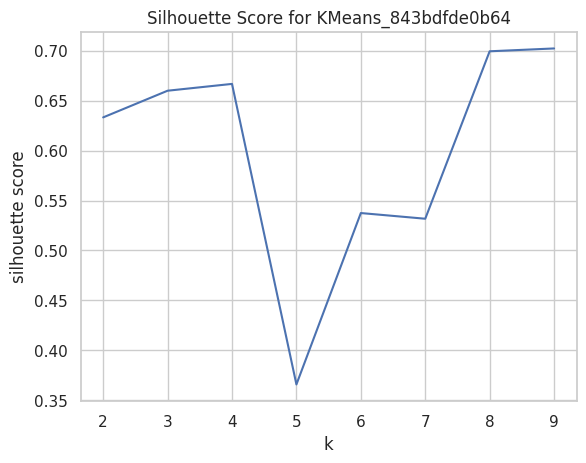

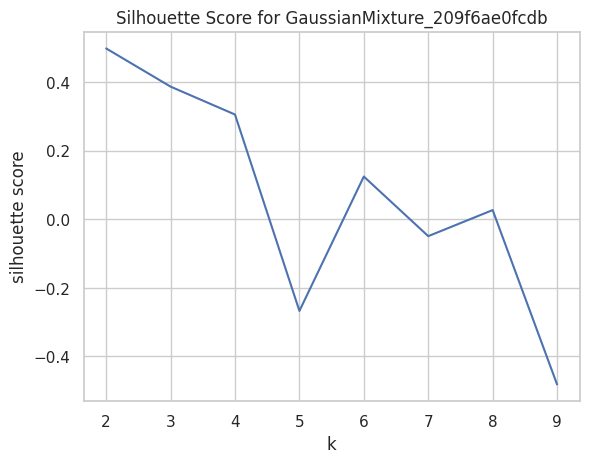

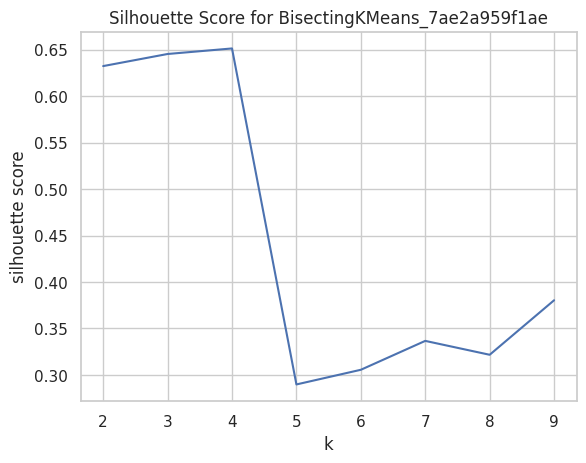

In [77]:
import matplotlib.pyplot as plt 
  
for model in models:
    plt.plot(range(2,10),silhouette_score[str(model)]) 
    plt.xlabel('k') 
    plt.ylabel('silhouette score') 
    plt.title(f'Silhouette Score for {model}') 
    plt.show()

In [78]:
chosen_model = models[0]
chosen_model

KMeans_843bdfde0b64

In [79]:
from pyspark.sql.functions import *
import builtins as py_builtin

# Garantir que silhouette_values é uma lista Python
silhouette_values = silhouette_score[str(chosen_model)]

# Calcular as diferenças consecutivas
differences = [silhouette_values[i+1] - silhouette_values[i] for i in range(len(silhouette_values)-1)]

# Encontrar o índice onde a mudança é mais brusca
optimal_k = differences.index(py_builtin.max(differences)) + 1

# Exibir o valor de optimal_k
print(f"Optimal k: {optimal_k}")

Optimal k: 4


In [80]:
# Trains a k-means model.
model = chosen_model.setSeed(42).setFeaturesCol("features").setK(optimal_k)
fitted_model = model.fit(client_features)
print(f"Cluster Sizes: {fitted_model.summary.clusterSizes}")

# Make predictions
predictions = fitted_model.transform(client_features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = fitted_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Sizes: [1106, 244, 97, 15]
Silhouette with squared euclidean distance = 0.6667681432368437
Cluster Centers: 
[0.10259631 0.0511846  0.0264672  0.00991457 0.01013069 0.01158968
 0.00557214 0.00503746 0.00819771 0.00465642 0.00198915 0.00080728]
[4.83452281e-01 6.11975549e-02 5.25335320e-02 1.69587337e-03
 4.09836066e-03 4.13561848e-02 9.53107129e-05 2.92740047e-04
 0.00000000e+00 0.00000000e+00 6.83060109e-03 0.00000000e+00]
[0.13730426 0.30508475 0.2497657  0.05172414 0.0262418  0.0131209
 0.04243587 0.00147275 0.00206186 0.01134021 0.01168385 0.01030928]
[0.07153476 0.15254237 0.00454545 0.         0.         0.
 0.         0.55238095 0.02666667 0.         0.         0.02380952]


In [81]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         2|   97|
|         0| 1106|
|         1|  244|
|         3|   15|
+----------+-----+



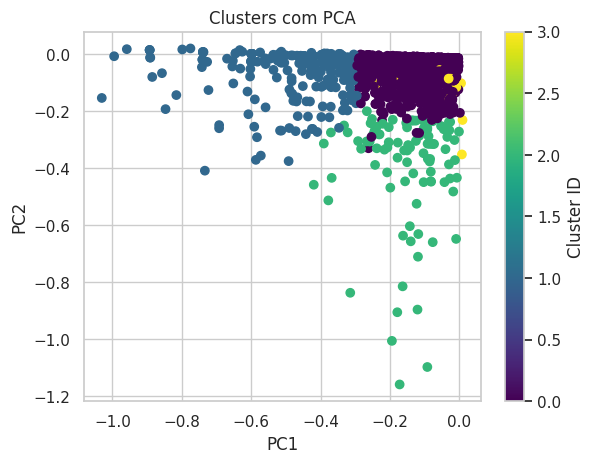

In [82]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import numpy as np

# Aplica PCA para reduzir para 2 dimensões
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(client_features)
pca_result = pca_model.transform(client_features)

# Extrai as componentes principais para plotar
pca_values = pca_result.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect()
pca_values = np.array(pca_values)

# Plota os pontos
plt.scatter(pca_values[:, 0], pca_values[:, 1], c=predictions.select("prediction").rdd.flatMap(lambda x: x).collect(), cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters com PCA")
plt.colorbar(label="Cluster ID")
plt.show()

In [83]:
cluster_profiles = predictions.groupBy("prediction").mean()

In [84]:
for c in cluster_profiles.columns:
    cluster_profiles = cluster_profiles.withColumn(c, F.round(c, 2))

In [85]:
cluster_profiles.show()

+----------+--------------+------------------+----------------+----------------+---------------+--------------+--------------+------------+-----------------+---------+---------+----------+----------------+---------------+
|prediction|  avg(user_id)|avg(average_price)|avg(total_views)|avg(electronics)|avg(appliances)|avg(furniture)|avg(computers)|avg(apparel)|avg(construction)|avg(auto)|avg(kids)|avg(sport)|avg(accessories)|avg(prediction)|
+----------+--------------+------------------+----------------+----------------+---------------+--------------+--------------+------------+-----------------+---------+---------+----------+----------------+---------------+
|         2|5.3901699602E8|            307.48|            18.0|           10.99|            3.0|          1.15|          0.29|        1.82|             0.02|     0.03|     0.23|      0.18|            0.29|            2.0|
|         0|5.4019363029E8|            229.76|            3.02|            1.16|           0.58|          0.45| 

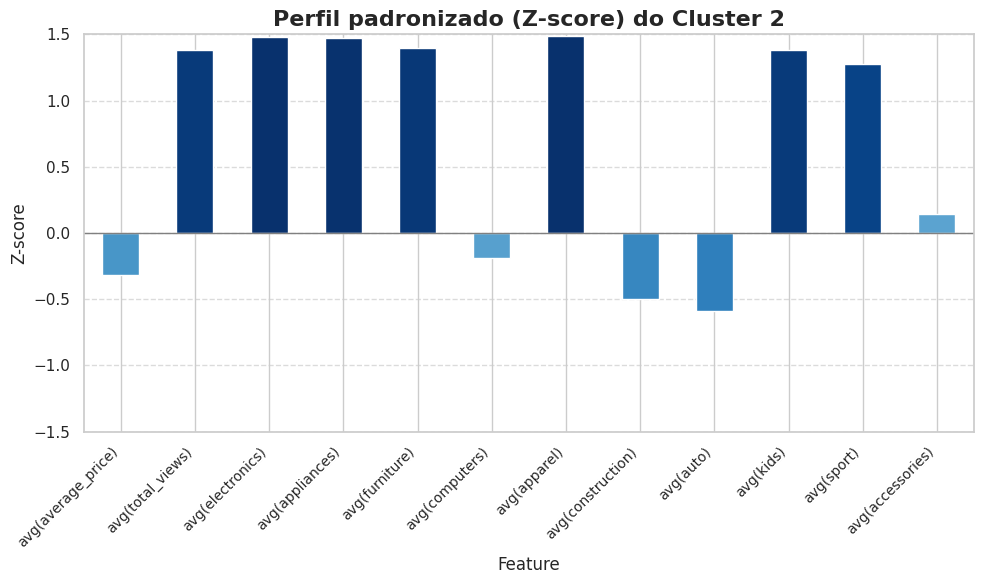

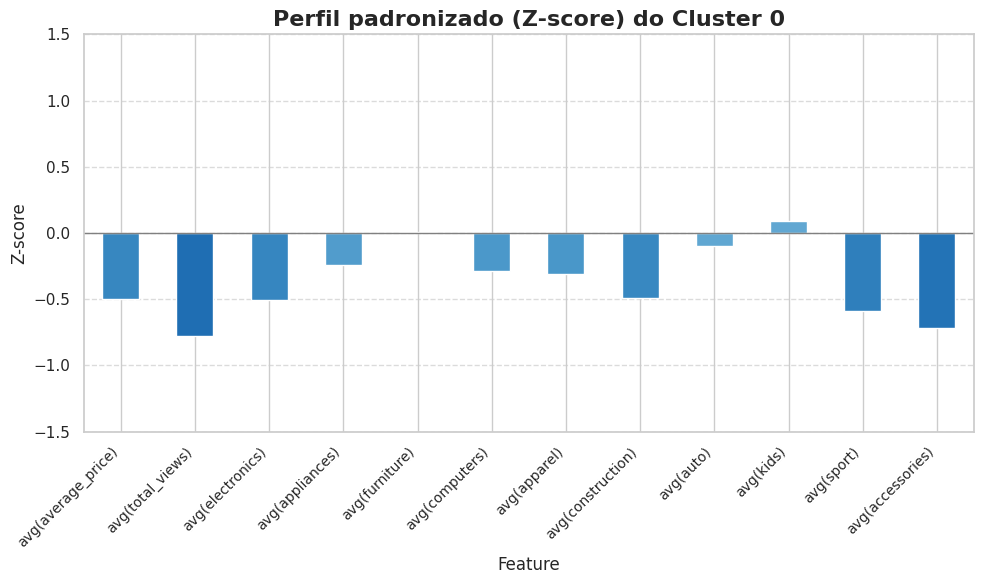

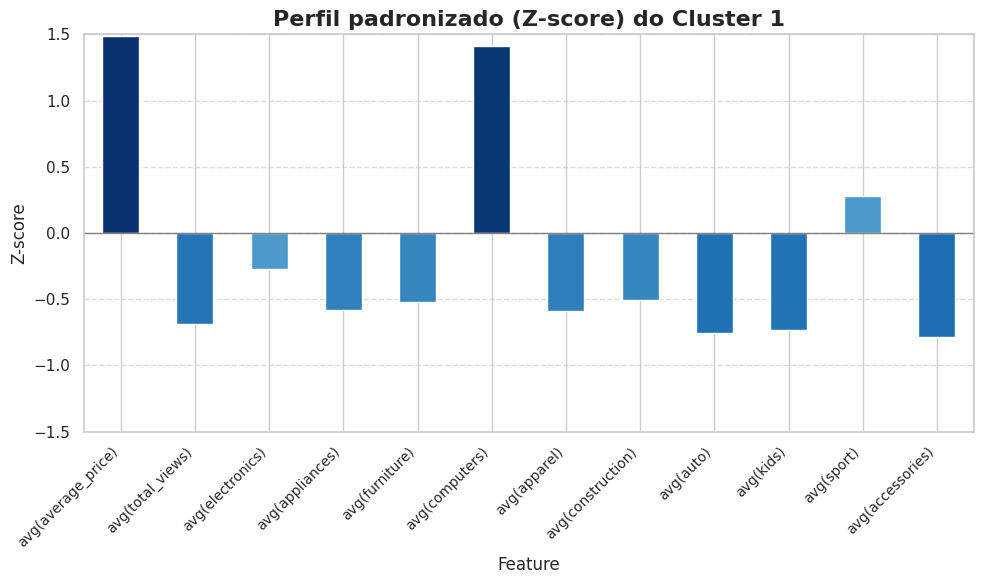

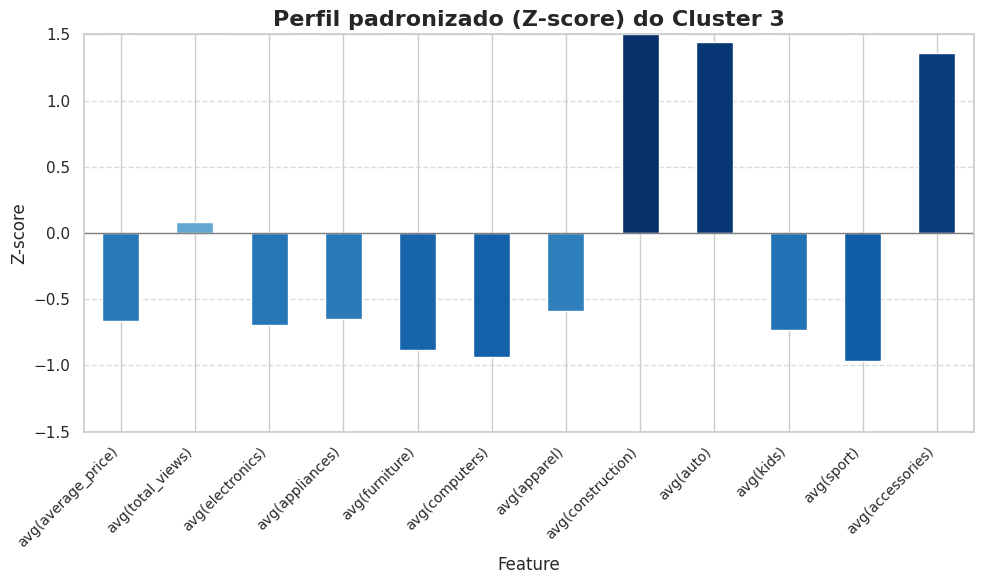

In [91]:
# Converter para Pandas
pdf = cluster_profiles.toPandas()
pdf.drop("avg(user_id)", axis=1, inplace=True)
pdf.drop("avg(prediction)", axis=1, inplace=True)

# Definir 'prediction' como índice
pdf.set_index("prediction", inplace=True)

# Aplicar normalização Z-score manualmente
pdf_zscore = (pdf - pdf.mean()) / pdf.std()

# Gerar gráfico por cluster
for cluster_id, row in pdf_zscore.iterrows():
    plt.figure(figsize=(10, 6))
    
    # Normalizar os valores de Z-score
    norm = colors.Normalize(vmin=-1.5, vmax=1.5)
    
    # Criar a paleta de cores azul
    color_map = plt.cm.Blues  # Paleta "Blues" para intensificar o tom de azul
    
    # Atribuir a cor de cada barra com base no valor do Z-score
    bars = row.plot(kind='bar', color=[color_map(norm(py_builtin.abs(value))) for value in row])
    
    # Título e labels do gráfico
    plt.title(f"Perfil padronizado (Z-score) do Cluster {cluster_id}", fontsize=16, fontweight='bold')
    plt.xlabel("Feature", fontsize=12)
    plt.ylabel("Z-score", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    
    # Limitar o eixo y entre -2 e 2
    plt.ylim(-1.5, 1.5)
    
    # Adicionar uma linha no zero para facilitar a visualização do centro
    plt.axhline(0, color='gray', linewidth=1)
    
    # Ativar o grid
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()

In [87]:
# write in a parquet file
predictions.drop("features_prescale", "features").write.parquet(data_dir + "user_cluster_df_full.parquet", mode="overwrite")